<a href="https://colab.research.google.com/github/JuliethLopez/chatbot_simpsons/blob/master/Modelo_de_Clasificacion_ngrams_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación usando Lenguaje Natural

In [1]:
# Librerias

import csv
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as plt
import nltk
import string
import itertools
from nltk import word_tokenize
from nltk.util import ngrams
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import layers, backend
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from sklearn. preprocessing import LabelEncoder

Using TensorFlow backend.


# Define algunas características iniciales

In [0]:
vocab_size = 23121 # número de palabras que integrarán el vocabulario
embedding_dim = 32 # dimensión del embeding de las palabras
max_length = 111  # longitud máxima de una oración (sentence filtrada con stopwords)
trunc_type='post' # donde truncar una oración (sentence, filtrada con stopwords)
padding_type='post'# donde hacer el padding (agregar ceros) en una oración (sentence, filtrada con stopwords)
oov_tok = "<OOV>"  # token para las palabras que queden fuera del vocabulario
training_portion = .8  # porcentaje de datos para entrenamiento

In [3]:
a = np.array([32]) # space
c = np.array(range(97,123)) # minúsculas
printab = np.hstack((a,c))
printable = np.array([chr(i) for i in printab])   
printable 

array([' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
       'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
       'z'], dtype='<U1')

## Lectura de los datos

In [0]:
complete_sentences = [] #
complete_lines = [] 
sentences = []
labels = [] # etiquetas preprocesadas
stopwords = []

In [5]:
import string
import re #regular expresions
# abre el archivo de datos y lo trata como un archivo csv
file = open('DFSMS.csv', 'r')
with file as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        # preprocess label
        #label_l = ' '.join(row[0].split()).lower().replace(' ','_') # lower case ans eliminate multiple spaces
        label_l = re.sub(' +', ' ',row[0].lower()) # lower case ans eliminate multiple spaces
        if (len(label_l)>2): # drop with empty label
            label = ''.join(c for c in label_l if c in printable)# filter only printable characters
            label = label.replace(' ','_')
            labels.append(label)
            # preprocess sentence
            #sentence_l = ' '.join(row[1].split()).lower().replace(' ','_') # lower case ans eliminate multiple spaces
            sentence_l = re.sub(' +', ' ',row[1].lower())
            sentence = ''.join(c for c in sentence_l if c in printable)
            complete_lines.append(row[0] + ': '+ row[1])
            complete_sentences.append(sentence)
            # preprocess stopwords
            for word in stopwords:
                token = " " + word + " "
                sentence = sentence.replace(token, " ")
            sentences.append(sentence)
 

# resumen de la lectura            
print(len(labels))
print(len(complete_sentences))
print(len(complete_lines))
print(len(sentences))

69171
69171
69171
69171


In [6]:
# Primera linea
print(labels[0]+'\n')
print(complete_sentences[0]+'\n')
print(complete_lines[0]+'\n')
print(sentences[0]+'\n')
# Tercer linea
print(labels[2]+'\n')
print(complete_sentences[2]+'\n')
print(complete_lines[2]+'\n')
print(sentences[2]+'\n')

lisa_simpson

wheres mr bergstrom

Lisa Simpson: Where's Mr. Bergstrom?

wheres mr bergstrom

bart_simpson

victory party under the slide

Bart Simpson: Victory party under the slide!

victory party under the slide



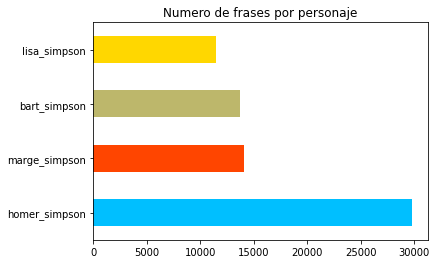

In [7]:
# Gráfico de barras de numero de frases por personaje
frec = pd.value_counts(labels)
plot = frec.plot(kind='barh',title='Numero de frases por personaje',color=['deepskyblue','orangered','darkkhaki','gold'])

# Separa datos de entrenamiento y validación 

In [8]:
train_size = int(len(sentences) * training_portion)
train_size # 80%

55336

#### Grupo de entrenamiento

In [9]:
train_sentences = sentences[:train_size] # Frases de entrenamiento 
train_labels = labels # Etiquetas de entrenamiento
print(len(train_sentences)) # Tamaño de frases de entrenamiento
print(len(train_labels)) # Tamaño de etiquetas de entrenamiento
print(train_sentences[:3]) 
print(train_labels[:3])

55336
69171
['wheres mr bergstrom', 'that life is worth living', 'victory party under the slide']
['lisa_simpson', 'lisa_simpson', 'bart_simpson']


#### Grupo de validación

In [10]:
validation_sentences = sentences[train_size:] # Frases de validacion
validation_labels = labels[train_size:] # Frases de validacion
print(len(validation_sentences)) # Tamaño de frases de validacion
print(len(validation_labels)) # Tamaño de etiquetas de validacion
print(validation_sentences[:3]) 
print(validation_labels[:3])

13835
13835
['', 'someone snitched whawhawhawhawhat are you gonna do to me', 'up or down']
['homer_simpson', 'homer_simpson', 'homer_simpson']


# Grafica de frecuencia de n-gramas

In [11]:
#Juntamos todo el texto en una sola linea
wordtk = ' '.join(train_sentences)

#Para dividir las frases
tokenstk = regexp_tokenize(wordtk, pattern="\w+")
tokenstk[:10]

['wheres',
 'mr',
 'bergstrom',
 'that',
 'life',
 'is',
 'worth',
 'living',
 'victory',
 'party']

In [12]:
from nltk.util import ngrams
trigrama = ngrams(tokenstk,3)
trigrama = [' '.join(grams) for grams in trigrama]
trigrama[:5]

['wheres mr bergstrom',
 'mr bergstrom that',
 'bergstrom that life',
 'that life is',
 'life is worth']

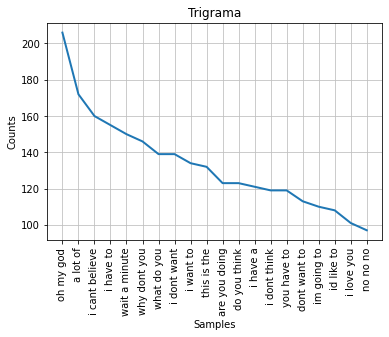

In [13]:
# Gráfica con los trigramas
freq = nltk.FreqDist(trigrama) #frecuencia de los tokens
eliminar = [] #filtramos tokens que se repiten mas de una vez
for key,val in freq.items():
  if (250>val>3):
    eliminar.append(str(key))

trigrama_limpio = []
for i in trigrama:
  if i in eliminar:
    trigrama_limpio.append(i)

freqnew = nltk.FreqDist(trigrama_limpio)
freqnew.plot(20, cumulative=False, title = "Trigrama")

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer3 = CountVectorizer(analyzer='word', ngram_range=(3,3))

In [75]:
X = vectorizer3.fit_transform(trigrama_limpio[:])
X

<70547x6411 sparse matrix of type '<class 'numpy.int64'>'
	with 49679 stored elements in Compressed Sparse Row format>

In [76]:
F = vectorizer3.get_feature_names() #Array mapping from feature integer indices to feature name.
vectorizer3.decode(F) #Decode the input into a string of unicode symbols.

['able to do',
 'about all the',
 'about in the',
 'about it im',
 'about me you',
 'about now no',
 'about the kids',
 'about the time',
 'about to get',
 'about what you',
 'about you and',
 'about you but',
 'about you know',
 'according to this',
 'across the street',
 'again all right',
 'again is mr',
 'ah come on',
 'ahead of me',
 'ahead of you',
 'all about it',
 'all around us',
 'all because of',
 'all by myself',
 'all figured out',
 'all going to',
 'all gonna die',
 'all have to',
 'all in the',
 'all it takes',
 'all kinds of',
 'all my fault',
 'all my friends',
 'all my life',
 'all of my',
 'all of them',
 'all of us',
 'all of you',
 'all of your',
 'all our stuff',
 'all out of',
 'all over the',
 'all right all',
 'all right and',
 'all right bart',
 'all right but',
 'all right dad',
 'all right everybody',
 'all right hey',
 'all right how',
 'all right if',
 'all right ill',
 'all right im',
 'all right its',
 'all right just',
 'all right lets',
 'all right lis

In [77]:
print('Vocabulary:')
print(vectorizer3.vocabulary_)
print("arreglo",X.toarray())
print("longitud",len(X.toarray()))

Vocabulary:
{'do you know': 924, 'you know where': 6091, 'hey thanks for': 1721, 'thanks for your': 4178, 'you got that': 6002, 'got that right': 1468, 'just going to': 2575, 'just like that': 2584, 'you cant go': 5890, 'im going to': 1999, 'going to miss': 1403, 'you thank you': 6228, 'thank you mr': 4165, 'guess this is': 1503, 'this is it': 4664, 'it you dont': 2445, 'you dont mind': 5955, 'what about that': 5469, 'with all the': 5699, 'oh this is': 3548, 'this is the': 4679, 'is the worst': 2298, 'the worst thing': 4508, 'thing that ever': 4598, 'that ever happened': 4191, 'ever happened to': 1115, 'happened to us': 1530, 'are you so': 287, 'im glad im': 1994, 'glad im not': 1334, 'for you to': 1227, 'im about to': 1986, 'to say is': 4955, 'is based on': 2235, 'dont think you': 1037, 'you realize what': 6165, 'what youre saying': 5545, 'to say it': 4956, 'cant believe it': 636, 'did you hear': 840, 'you hear that': 6032, 'you are not': 5839, 'not allowed to': 3312, 'you can tell': 

In [78]:
import pandas as pd
pd.DataFrame(X.toarray(),columns=vectorizer3.get_feature_names())

,able to do,about all the,about in the,about it im,about me you,about now no,about the kids,about the time,about to get,about what you,about you and,about you but,about you know,according to this,across the street,again all right,again is mr,ah come on,ahead of me,ahead of you,all about it,all around us,all because of,all by myself,all figured out,all going to,all gonna die,all have to,all in the,all it takes,all kinds of,all my fault,all my friends,all my life,all of my,all of them,all of us,all of you,all of your,all our stuff,...,youre not gonna,youre not in,youre not listening,youre not mad,youre not really,youre not supposed,youre not the,youre old enough,youre on your,youre one of,youre out of,youre ready to,youre right but,youre right im,youre right ive,youre right marge,youre supposed to,youre taking this,youre telling me,youre the boss,youre the coolest,youre the greatest,youre the most,youre the one,youre the only,youre the worst,youre thinking of,youre trying to,youre up to,youve always been,youve been in,youve done it,youve ever done,youve got the,youve got to,youve gotta be,youve gotta get,youve gotta help,youve had enough,zap zap zap
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70542,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
70543,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
70544,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
70545,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
train_sequences=X.toarray

# Tokenizer/n-gramas

Tokenizer permite vectorizar un corpus de texto, convirtiendo cada texto en una secuencia de enteros (cada entero es el índice de un token en un diccionario)

In [16]:
print(tokenizer.word_index['where'])
print(tokenizer.word_index['living'])
print(tokenizer.word_index['girls'])
print(tokenizer.word_index['people'])
print(tokenizer.word_index['thanks'])

122
581
517
130
204


In [17]:
# El corpus se toma del train_sentence 

test_seq = []

# Primera línea en el corpus 
print('First Line = ',train_sentences[3],'\n')

# Transforma la primera línea del train_sentences en secuencias deacuerdo con el diccionario

token_test=tokenizer.texts_to_sequences([train_sentences[3]])[0]
print('First Line into Sequence =',token_test,'\n')

# Crea fragmentos de la línea y crea los datos por piezas ordenadas
for j in range(1, len(token_test)):
  # Iterador sobre los elementos de la línea.
  n_gram_test=token_test[:j+1]
  print('n-gram =',n_gram_test)
  # Añade todos los resultados secuenciales
  test_seq.append(n_gram_test)
  print('sequence = ',test_seq,'\n')

# Determina el n-grama más extenso
max_seq_test_len = max([len(x) for x in test_seq])
# Relleno
test_seq = np.array(pad_sequences(test_seq, maxlen=max_seq_test_len, padding='pre'))
print("Final n-gram Data:\n\n",  test_seq,'\n')
print('Shape of Data: ',np.shape(test_seq))

First Line =  mr bergstrom mr bergstrom 

First Line into Sequence = [143, 3442, 143, 3442] 

n-gram = [143, 3442]
sequence =  [[143, 3442]] 

n-gram = [143, 3442, 143]
sequence =  [[143, 3442], [143, 3442, 143]] 

n-gram = [143, 3442, 143, 3442]
sequence =  [[143, 3442], [143, 3442, 143], [143, 3442, 143, 3442]] 

Final n-gram Data:

 [[   0    0  143 3442]
 [   0  143 3442  143]
 [ 143 3442  143 3442]] 

Shape of Data:  (3, 4)


### Grupo de  Entrenamiento

In [0]:
# Crear la secuencia de texto para crear datos de entrenamiento

input_sequences_train = []
train_labels_ng =[]
for (line,j) in zip(train_sentences,range(1, len(train_sentences))):
  lab = train_labels[j]
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    input_sequences_train.append(n_gram_sequence)
    train_labels_ng.append(lab)

In [19]:
print(len(input_sequences_train))
print(len(train_labels_ng))

425898
425898


In [20]:
# Relleno

max_sequence_len_tran = max([len(x) for x in input_sequences_train])
input_sequences_train = np.array(pad_sequences(input_sequences_train, maxlen=max_sequence_len_tran, padding='pre'))

# Cree predictores y etiquetas (las etiquetas son la palabra final de cada secuencia. Ex: Datos: wheres mr bergstrom, Personaje: )

train_sentences_ngrams = input_sequences_train
print(len(train_sentences_ngrams))

425898


In [21]:
np.shape(train_sentences_ngrams)

(425898, 111)

In [22]:
label_size = 4
label_tokenizer = Tokenizer(num_words = label_size,oov_token=oov_tok, filters = '')
label_tokenizer.fit_on_texts(train_labels_ng)
label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels_ng))
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels_ng))

# flatten the nested list and tranaform to an np array
label_seq = np.array([item for items in label_seq for item in items])
training_label_seq = np.array([item for items in training_label_seq for item in items])
training_label_seq
print(len(training_label_seq))

425898


In [0]:
#preprocessing.LabelEncoder()
encoder = LabelEncoder()

encoder.fit(label_seq)
train_labels_ngrams = encoder.transform(training_label_seq)
num_classes = label_size

In [0]:
# Codificación One-Hot 
train_labels_ngrams_codf = tf.keras.utils.to_categorical(train_labels_ngrams, num_classes)

In [25]:
print(input_sequences_train)

[[   0    0    0 ...    0  369  143]
 [   0    0    0 ...  369  143 3442]
 [   0    0    0 ...    0    9  155]
 ...
 [   0    0    0 ...    2    4 3730]
 [   0    0    0 ...    4 3730   26]
 [   0    0    0 ... 3730   26  415]]


In [26]:
len(train_labels_ngrams_codf)

425898

#### Grupo de Validacion 

In [0]:
# Crear la secuencia de texto para crear datos de validacion

input_sequences_vt = []
validation_labels_ng =[]
for (line,j) in zip(validation_labels,range(1, len(validation_sentences))):
  lab = validation_labels[j]
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    input_sequences_vt.append(n_gram_sequence)
    validation_labels_ng.append(lab)

In [28]:
len(validation_sentences)

13835

In [29]:
print(len(input_sequences_vt))
print(len(validation_labels_ng))

13834
13834


In [30]:
# Relleno

max_sequence_len_vt = max([len(x) for x in input_sequences_vt])
input_sequences_vt = np.array(pad_sequences(input_sequences_vt, maxlen=max_sequence_len_vt, padding='pre'))

validation_sentences_ngrams = input_sequences_vt
print(len(validation_sentences_ngrams))

13834


In [31]:
np.shape(validation_sentences_ngrams)

(13834, 2)

In [32]:
label_size = 4
label_tokenizer = Tokenizer(num_words = label_size,oov_token=oov_tok, filters = '')
label_tokenizer.fit_on_texts(validation_labels_ng)
label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels_ng))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels_ng))

# flatten the nested list and tranaform to an np array
label_seq = np.array([item for items in label_seq for item in items])
validation_label_seq = np.array([item for items in validation_label_seq for item in items])
validation_label_seq
print(len(validation_label_seq))

13834


In [0]:
#preprocessing.LabelEncoder()
encoder = LabelEncoder()

encoder.fit(label_seq)
validation_labels_ngrams = encoder.transform(validation_label_seq)
num_classes = 4

In [0]:
# Codificación One-Hot 
validation_labels_ngrams_codf = tf.keras.utils.to_categorical(validation_labels_ngrams, num_classes)

In [35]:
print(input_sequences_vt)

[[ 58 194]
 [ 58 194]
 [ 58 194]
 ...
 [ 81 194]
 [ 56 194]
 [ 81 194]]


In [36]:
len(validation_labels_ngrams_codf)

13834

# Construccion del Modelo

In [37]:
print(len(train_labels_ngrams_codf))
print(len(train_sentences_ngrams))
print(len(validation_labels_ngrams_codf))
print(len(validation_sentences_ngrams))

425898
425898
13834
13834


In [38]:
model = tf.keras.Sequential([
                             
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 111, 32)           739872    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               4224      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 744,612
Trainable params: 744,612
Non-trainable params: 0
_________________________________________________________________


# Entrenamiento del modelo

In [39]:
num_epochs = 40
history = model.fit(train_sentences_ngrams, train_labels_ngrams_codf, epochs=num_epochs, validation_data=(validation_sentences_ngrams,validation_labels_ngrams_codf), verbose=True)

Epoch 1/40
13310/13310 [==============================] - 108s 8ms/step - loss: 0.9238 - accuracy: 0.5456 - val_loss: 25.3780 - val_accuracy: 0.4799
Epoch 2/40
 4333/13310 [========>.....................] - ETA: 1:14 - loss: 0.7881 - accuracy: 0.6296

KeyboardInterrupt: ignored

In [0]:
def plot_graphs(history, string):
  plt.title(string+' con 3 epochs')
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")